<a href="https://colab.research.google.com/github/thejarlid/makemore/blob/main/Makemore_pt5_Building_a_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-09-11 02:38:33--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2025-09-11 02:38:34 (8.42 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [48]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [49]:
# build the vocabulary of characters and mappints to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [50]:
# build the dataset

blocksize = 3 # context length: how many characters do we take to predict the next one
X, Y = [], []
for w in words:
  context = [0] * blocksize
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [51]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [52]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [91]:
# build the data set
block_size = 8

def build_dataset(words):
  blocksize = 3 # context length: how many characters do we take to predict the next one
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [92]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a
......ma --> r
.....mar --> k
....mark --> u
...marku --> s
..markus --> .


In [116]:
# ----------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

# ----------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [56]:
torch.manual_seed(42)

In [120]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the mlp

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])



# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


76579


In [118]:
# for layer in model.layers:
  # print(layer.__class__.__name__, ':', layer.out.shape)

AttributeError: 'Embedding' object has no attribute 'out'

In [121]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
  lossi.append(loss.log10().item())


      0/ 200000: 3.477280
  10000/ 200000: 2.017171
  20000/ 200000: 2.181153
  30000/ 200000: 2.288994
  40000/ 200000: 1.501535
  50000/ 200000: 1.803213
  60000/ 200000: 1.654849
  70000/ 200000: 1.969386
  80000/ 200000: 1.769288
  90000/ 200000: 1.923363
 100000/ 200000: 1.927734
 110000/ 200000: 1.998590
 120000/ 200000: 1.863428
 130000/ 200000: 1.777465
 140000/ 200000: 2.463946
 150000/ 200000: 1.951015
 160000/ 200000: 1.941998
 170000/ 200000: 2.492326
 180000/ 200000: 1.765069
 190000/ 200000: 2.182067


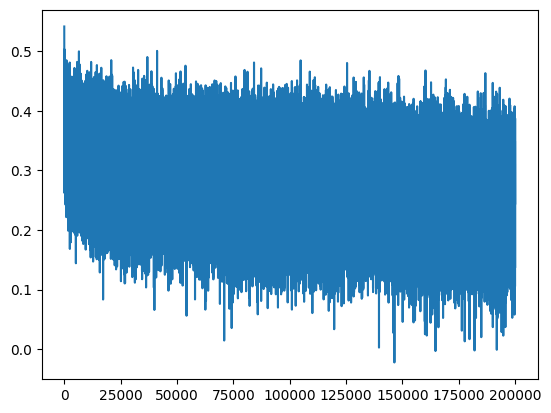

In [122]:
plt.plot(lossi)

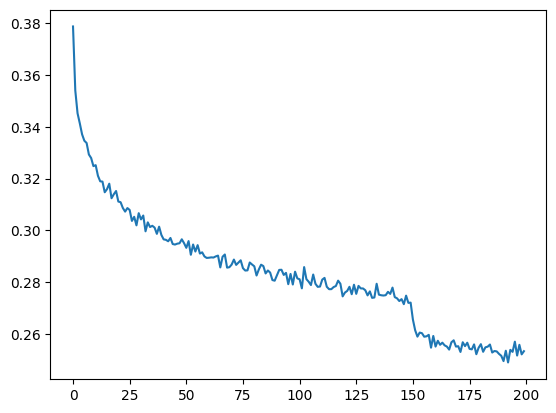

In [123]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [125]:
# put layers into eval mode (needed for batch norm especially)
for layer in model.layers:
  layer.training = False

In [126]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.7688084840774536
val 1.9885228872299194


In [127]:
# sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size # initialize all with ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)

    # if we sample the special . token break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated word

abdalrie.
jazzlin.
enoxmond.
nehanang.
kung.
ziyah.
xayley.
rosamariah.
carlee.
azhara.
navi.
quentez.
amola.
brandia.
mina.
devrens.
marsha.
valler.
tameem.
twartu.
